In [3]:
# ===============================================================
# Notebook en 1 sola celda: Forecasting de Tickets + Staffing (SLA)
# Arregla incompatibilidad Prophet ↔ NumPy 2.0 fijando numpy==1.26.4
# ===============================================================

# --- Instalación de dependencias (silenciosa) ---
import sys, subprocess, pkgutil, importlib
def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Fijamos NumPy < 2.0 y luego Prophet
pip_install(["numpy==1.26.4", "pandas>=1.5,<2.3", "matplotlib>=3.7,<3.9", "scipy>=1.10,<1.13"])
pip_install(["prophet==1.1.5", "cmdstanpy<1.2"])  # versiones estables en Colab

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import timedelta

np.random.seed(42)

# ===============================================================
# 1) Simulación de datos (tickets diarios con regresores)
# ===============================================================
start = "2022-01-01"
end   = "2024-12-31"
df = pd.DataFrame({"ds": pd.date_range(start, end, freq="D")})

# Tendencia suave
trend = 150 + 0.03 * np.arange(len(df))

# Estacionalidad semanal (pico lunes/martes, baja fin de semana)
dow = df['ds'].dt.dayofweek
weekly = (np.where(dow==0, 20, 0) +  # lunes
          np.where(dow==1, 15, 0) +  # martes
          np.where(dow==2, 10, 0) +  # miércoles
          np.where(dow>=5, -25, 0))  # sáb/dom

# Festivos (ejemplo: ajusta a tu país)
festivos = pd.to_datetime([
    "2022-01-01","2022-12-25","2023-01-01","2023-12-25","2024-01-01","2024-12-25"
])
df["is_holiday"] = df["ds"].isin(festivos).astype(int)

# Campañas y lanzamientos (regresores)
campania_fechas    = pd.date_range("2023-11-20", periods=10, freq="D")  # BF/Cyber
lanzamiento_fechas = pd.to_datetime(["2023-03-15","2024-05-10"])
df["campania"]     = df["ds"].isin(campania_fechas).astype(int)
df["lanzamiento"]  = df["ds"].isin(lanzamiento_fechas).astype(int)

# Efecto de regresores
reg_effect = 30*df["campania"] + 18*df["lanzamiento"] + 12*df["is_holiday"]

# Ruido y señal final
noise = np.random.normal(0, 12, size=len(df))
df["y"] = (trend + weekly + reg_effect + noise).clip(min=0)

# ===============================================================
# 2) Split temporal train/test
# ===============================================================
cutoff = df['ds'].max() - pd.Timedelta(days=60)
train = df[df['ds'] <= cutoff].copy()
test  = df[df['ds'] >  cutoff].copy()

# ===============================================================
# 3) Modelo Prophet con regresores
# ===============================================================
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.9
)
for col in ["campania", "lanzamiento", "is_holiday"]:
    m.add_regressor(col)

m.fit(train[["ds","y","campania","lanzamiento","is_holiday"]])

# Horizonte = test + 14 días extra
h = len(test) + 14
future = m.make_future_dataframe(periods=h, freq="D")
future = future.merge(df[["ds","campania","lanzamiento","is_holiday"]], on="ds", how="left")
future[["campania","lanzamiento","is_holiday"]] = future[["campania","lanzamiento","is_holiday"]].fillna(0)

forecast = m.predict(future)

# ===============================================================
# 4) Métricas en test
# ===============================================================
eval_df = test[["ds","y"]].merge(forecast[["ds","yhat","yhat_lower","yhat_upper"]], on="ds", how="left")
mae  = float(np.mean(np.abs(eval_df["y"] - eval_df["yhat"])))
rmse = float(np.sqrt(np.mean((eval_df["y"] - eval_df["yhat"])**2)))
mape = float(np.mean(np.abs((eval_df["y"] - eval_df["yhat"]) / np.maximum(1, eval_df["y"]))) * 100)
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

# ===============================================================
# 5) Visualizaciones principales
# (sin estilos/colores forzados)
# ===============================================================
fig1 = m.plot(forecast)
plt.title("Forecast de tickets (yhat, IC 90%)")

fig2 = m.plot_components(forecast)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(eval_df["ds"], eval_df["y"], label="Real")
plt.plot(eval_df["ds"], eval_df["yhat"], label="Predicho", linestyle="--")
plt.fill_between(eval_df["ds"], eval_df["yhat_lower"], eval_df["yhat_upper"], alpha=0.2, label="IC 90%")
plt.title("Real vs Predicho (ventana de test)")
plt.legend(); plt.tight_layout(); plt.show()

# ===============================================================
# 6) De forecast a agentes requeridos (Erlang C simplificado)
# ===============================================================
AHT_min = 6.0   # Average Handling Time (min)
SLA_sec = 60    # objetivo de tiempo
SLA_obj = 0.80  # 80% en 60s
hours_per_day = 8

def erlang_c(traffic_intensity, agents):
    rho = traffic_intensity / agents
    if rho >= 1:
        return 1.0
    summation = sum((traffic_intensity**k)/np.math.factorial(k) for k in range(agents))
    p0 = 1.0 / (summation + (traffic_intensity**agents)/(np.math.factorial(agents) * (1 - rho)))
    pc = ((traffic_intensity**agents) / (np.math.factorial(agents) * (1 - rho))) * p0
    return pc

def service_level(agents, lam_per_hour, aht_min, target_sec):
    mu_per_min = 60.0 / aht_min
    lam_per_min = lam_per_hour / 60.0
    a = lam_per_min / mu_per_min
    pc = erlang_c(a, agents)
    expo = np.exp(-(agents*mu_per_min - lam_per_min) * (target_sec/60.0))
    return max(0.0, min(1.0, 1 - pc * expo))

def required_agents_for_day(tickets_day, aht_min=AHT_min, sla_target=SLA_obj, sla_sec=SLA_sec, hours=hours_per_day):
    if tickets_day <= 0:
        return 0
    lam_h = tickets_day / hours
    lower = max(1, int(np.ceil(lam_h * aht_min/60)))  # base mínima
    n = lower
    while service_level(n, lam_h, aht_min, sla_sec) < sla_target and n < 1000:
        n += 1
    return n

planning = forecast[forecast["ds"] > test["ds"].max()].copy().head(30)
planning["tickets_pred"] = planning["yhat"].clip(lower=0).round()
planning["agentes_req"] = planning["tickets_pred"].apply(lambda x: required_agents_for_day(int(x)))

# ===============================================================
# 7) Gráficos de planning + tabla de salida
# ===============================================================
plt.figure(figsize=(10,4))
plt.plot(planning["ds"], planning["tickets_pred"], label="Tickets previstos")
plt.title("Tickets previstos (próximos 30 días)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.step(planning["ds"], planning["agentes_req"], where="mid", label="Agentes requeridos (SLA 80%<60s)")
plt.title("Agentes requeridos por día")
plt.legend(); plt.tight_layout(); plt.show()

planning_out = planning[["ds","yhat","yhat_lower","yhat_upper","tickets_pred","agentes_req"]].rename(
    columns={"ds":"fecha","yhat":"pred","yhat_lower":"ic_inf","yhat_upper":"ic_sup"}
)
print("\nTabla ejecutiva (primeros 10 días):")
print(planning_out.head(10).to_string(index=False))


AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj3pbf3k/jrmm9919.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnj3pbf3k/ukv9auum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17776', 'data', 'file=/tmp/tmpnj3pbf3k/jrmm9919.json', 'init=/tmp/tmpnj3pbf3k/ukv9auum.json', 'output', 'file=/tmp/tmpnj3pbf3k/prophet_modely0kkmadl/prophet_model-20250810101916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 8.93 | RMSE: 11.27 | MAPE: 5.07%


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

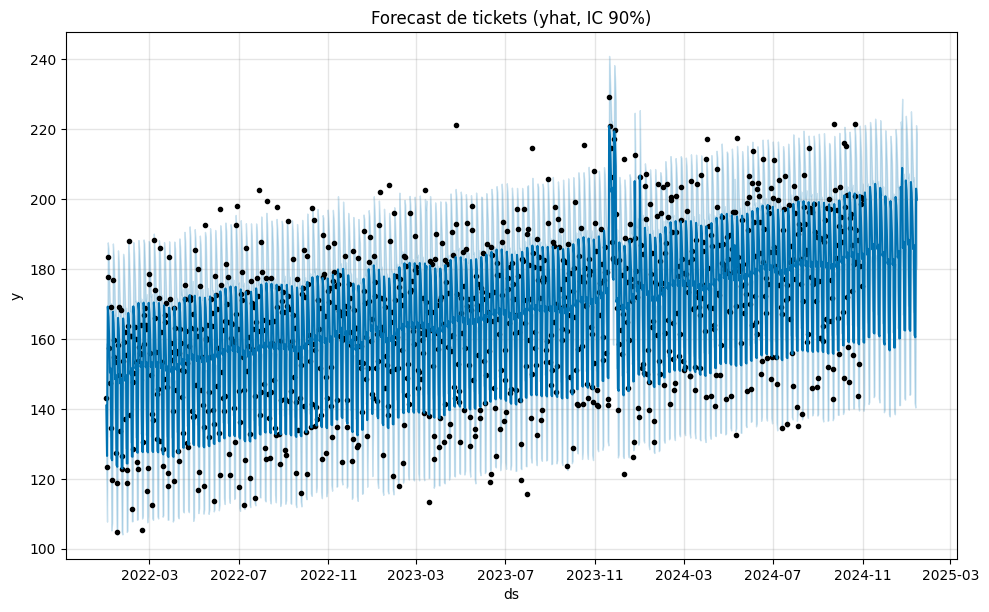

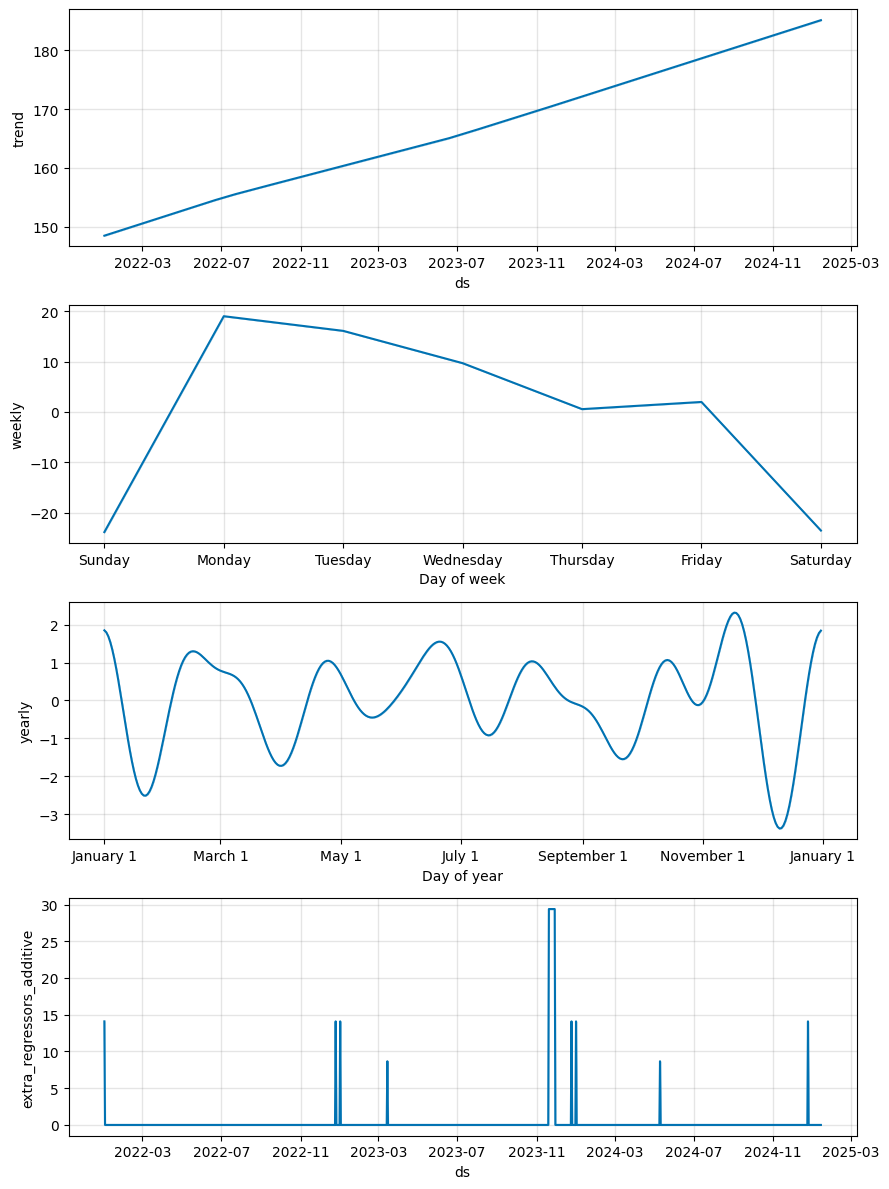

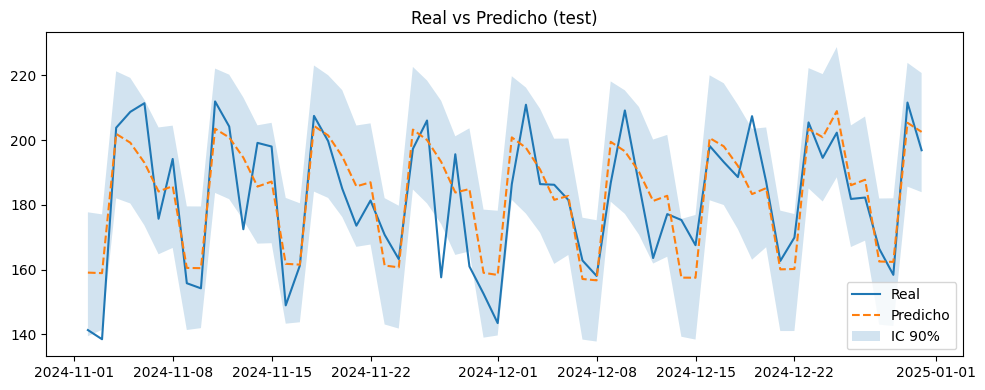

/tmp/ipython-input-2060544627.py:100: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  summation = sum((a**k)/np.math.factorial(k) for k in range(n))
/tmp/ipython-input-2060544627.py:101: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  p0 = 1.0 / (summation + (a**n)/(np.math.factorial(n) * (1 - rho)))
/tmp/ipython-input-2060544627.py:102: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return ((a**n) / (np.math.factorial(n) * (1 - rho))) * p0


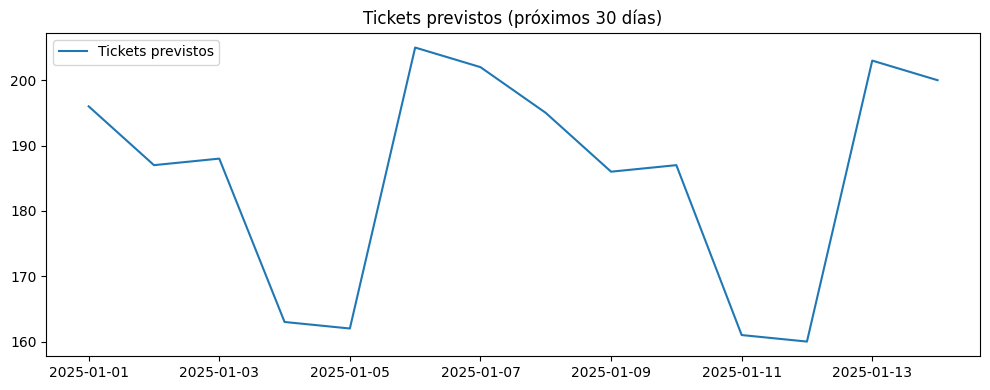

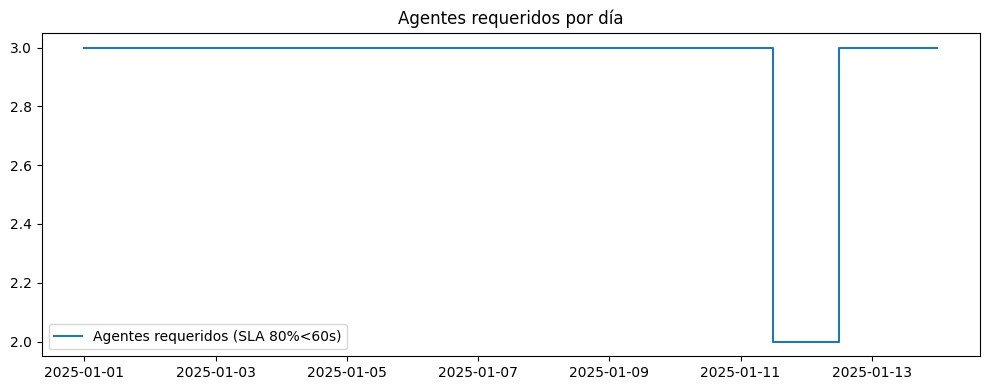


Tabla ejecutiva (primeros 10 días):
     fecha       pred     ic_inf     ic_sup  tickets_pred  agentes_req
2025-01-01 196.172866 177.406248 214.612714         196.0            3
2025-01-02 187.040299 169.468350 206.089187         187.0            3
2025-01-03 188.393665 169.894926 207.355382         188.0            3
2025-01-04 162.787882 144.005108 180.303311         163.0            3
2025-01-05 162.312664 144.246459 180.992696         162.0            3
2025-01-06 204.923325 185.215553 225.151803         205.0            3
2025-01-07 201.786820 183.356443 219.992160         202.0            3
2025-01-08 195.123928 176.254360 213.130079         195.0            3
2025-01-09 185.734270 167.763802 205.156532         186.0            3
2025-01-10 186.869482 169.299962 206.268508         187.0            3


In [3]:
# ===============================================================
# Colab: UNA SOLA CELDA (ajuste de versiones + proyecto completo)
# Forecasting de Tickets + Dimensionamiento de Agentes (SLA)
# ===============================================================

import sys, subprocess, os

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# 0) Verificar NumPy y reinstalar si no es 1.26.4 (Prophet compatible)
need_restart = False
try:
    import numpy as _np
    if _np.__version__ != "1.26.4":
        need_restart = True
except Exception:
    need_restart = True

if need_restart:
    pip_install(["numpy==1.26.4", "pandas>=1.5,<2.3", "matplotlib>=3.7,<3.9", "scipy>=1.10,<1.13"])
    pip_install(["prophet==1.1.5", "cmdstanpy<1.2"])
    print("✅ Dependencias listas. Reiniciando el runtime… vuelve a ejecutar esta misma celda.")
    os.kill(os.getpid(), 9)

# 1) Imports (con NumPy 1.26.4 cargado)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
np.random.seed(42)

# 2) Simulación de datos (tickets diarios + regresores)
start, end = "2022-01-01", "2024-12-31"
df = pd.DataFrame({"ds": pd.date_range(start, end, freq="D")})

trend = 150 + 0.03 * np.arange(len(df))
dow = df['ds'].dt.dayofweek
weekly = (np.where(dow==0, 20, 0) +
          np.where(dow==1, 15, 0) +
          np.where(dow==2, 10, 0) +
          np.where(dow>=5, -25, 0))

festivos = pd.to_datetime([
    "2022-01-01","2022-12-25","2023-01-01","2023-12-25","2024-01-01","2024-12-25"
])
df["is_holiday"] = df["ds"].isin(festivos).astype(int)

campania_fechas    = pd.date_range("2023-11-20", periods=10, freq="D")
lanzamiento_fechas = pd.to_datetime(["2023-03-15","2024-05-10"])
df["campania"]     = df["ds"].isin(campania_fechas).astype(int)
df["lanzamiento"]  = df["ds"].isin(lanzamiento_fechas).astype(int)

reg_effect = 30*df["campania"] + 18*df["lanzamiento"] + 12*df["is_holiday"]
noise = np.random.normal(0, 12, size=len(df))
# ⬇️ FIX: usar lower=0 en vez de min=0
df["y"] = (trend + weekly + reg_effect + noise)
df["y"] = pd.Series(df["y"]).clip(lower=0)

# 3) Split temporal
cutoff = df['ds'].max() - pd.Timedelta(days=60)
train = df[df['ds'] <= cutoff].copy()
test  = df[df['ds'] >  cutoff].copy()

# 4) Modelo Prophet con regresores
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, interval_width=0.9)
for col in ["campania", "lanzamiento", "is_holiday"]:
    m.add_regressor(col)
m.fit(train[["ds","y","campania","lanzamiento","is_holiday"]])

h = len(test) + 14
future = m.make_future_dataframe(periods=h, freq="D")
future = future.merge(df[["ds","campania","lanzamiento","is_holiday"]], on="ds", how="left")
future[["campania","lanzamiento","is_holiday"]] = future[["campania","lanzamiento","is_holiday"]].fillna(0)
forecast = m.predict(future)

# 5) Métricas
eval_df = test[["ds","y"]].merge(forecast[["ds","yhat","yhat_lower","yhat_upper"]], on="ds", how="left")
mae  = float(np.mean(np.abs(eval_df["y"] - eval_df["yhat"])))
rmse = float(np.sqrt(np.mean((eval_df["y"] - eval_df["yhat"])**2)))
mape = float(np.mean(np.abs((eval_df["y"] - eval_df["yhat"]) / np.maximum(1, eval_df["y"]))) * 100)
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

# 6) Visualizaciones
fig1 = m.plot(forecast); plt.title("Forecast de tickets (yhat, IC 90%)")
fig2 = m.plot_components(forecast); plt.show()

plt.figure(figsize=(10,4))
plt.plot(eval_df["ds"], eval_df["y"], label="Real")
plt.plot(eval_df["ds"], eval_df["yhat"], label="Predicho", linestyle="--")
plt.fill_between(eval_df["ds"], eval_df["yhat_lower"], eval_df["yhat_upper"], alpha=0.2, label="IC 90%")
plt.title("Real vs Predicho (test)"); plt.legend(); plt.tight_layout(); plt.show()

# 7) Staffing por Erlang C (simplificado)
AHT_min, SLA_sec, SLA_obj, hours_per_day = 6.0, 60, 0.80, 8

def erlang_c(a, n):
    rho = a / n
    if rho >= 1: return 1.0
    summation = sum((a**k)/np.math.factorial(k) for k in range(n))
    p0 = 1.0 / (summation + (a**n)/(np.math.factorial(n) * (1 - rho)))
    return ((a**n) / (np.math.factorial(n) * (1 - rho))) * p0

def service_level(n, lam_h, aht_min, target_sec):
    mu_m = 60.0 / aht_min
    lam_m = lam_h / 60.0
    a = lam_m / mu_m
    pc = erlang_c(a, n)
    return max(0.0, min(1.0, 1 - pc * np.exp(-(n*mu_m - lam_m) * (target_sec/60.0))))

def required_agents_for_day(tickets_day, aht_min=AHT_min, sla_target=SLA_obj, sla_sec=SLA_sec, hours=hours_per_day):
    if tickets_day <= 0: return 0
    lam_h = tickets_day / hours
    n = max(1, int(np.ceil(lam_h * aht_min/60)))
    while service_level(n, lam_h, aht_min, sla_sec) < sla_target and n < 1000:
        n += 1
    return n

planning = forecast[forecast["ds"] > test["ds"].max()].copy().head(30)
planning["tickets_pred"] = pd.Series(planning["yhat"]).clip(lower=0).round()
planning["agentes_req"] = planning["tickets_pred"].apply(lambda x: required_agents_for_day(int(x)))

plt.figure(figsize=(10,4))
plt.plot(planning["ds"], planning["tickets_pred"], label="Tickets previstos")
plt.title("Tickets previstos (próximos 30 días)"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.step(planning["ds"], planning["agentes_req"], where="mid", label="Agentes requeridos (SLA 80%<60s)")
plt.title("Agentes requeridos por día"); plt.legend(); plt.tight_layout(); plt.show()

planning_out = planning[["ds","yhat","yhat_lower","yhat_upper","tickets_pred","agentes_req"]].rename(
    columns={"ds":"fecha","yhat":"pred","yhat_lower":"ic_inf","yhat_upper":"ic_sup"}
)
print("\nTabla ejecutiva (primeros 10 días):")
print(planning_out.head(10).to_string(index=False))
